In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from fastai.vision import (load_learner, ImageList, imagenet_stats, 
                           get_transforms, DatasetType, pil2tensor)
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob
from PIL import Image
from fastai.vision import Image as ImageFastai   # name collision
import cv2
from tqdm import tqdm

from utils_cv.common.gpu import db_num_workers, which_processor
import torch

import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [3]:
learn = load_learner('train/')

In [4]:
learn.data

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: train;

Test: None

# Add new data (Don't use, this is for a separate test set 

In [5]:
path = Path('train/')
IM_SIZE       = 224
BATCH_SIZE    = 64

In [6]:
# TODO remove transform at inference :D 
tfms = get_transforms(max_zoom=1.05, max_warp=None)
      
data = (ImageList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2, seed=10)
        .label_from_folder()
        .transform(size=IM_SIZE)
        .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
        .normalize(imagenet_stats))

<class 'fastai.vision.image.Image'>


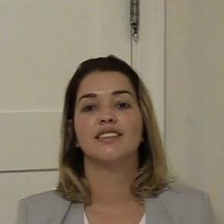

In [7]:
img = data.train_ds[8][0]
print(type(img))
img

# Inference loop

In [9]:
import sys
sys.path.insert(0, "../input/blazeface-pytorch")
sys.path.insert(0, "../input/deepfakes-inference-demo")

from blazeface import BlazeFace
facedet = BlazeFace().to('cuda:0')
facedet.load_weights("../input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("../input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 25  
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [10]:
TEST_PATH = Path('../input/deepfake-detection-challenge/test_videos/')

In [14]:
# USING THE ORIGINAL LOOP :( 

def predict_on_videos_original(file_name):
    
    if not os.path.exists(TEST_PATH/file_name):
        print(f"File {TEST_PATH/file_name} does not exist")
        return
    
    faces = face_extractor.process_video(TEST_PATH/file_name, margin=0.6)
    face_extractor.keep_only_best_face(faces)

    i = 0
    # TODO: Combine with data to put to different folders :D 
    preds = torch.Tensor()
    
    # Remove temp
    files = glob.glob('temp/*.jpeg')
    for f in files:
        os.remove(f)
    
    for frame_face in faces:        
        for face in frame_face["faces"]:    # should only  got 1 here

            # Save to temp for batch predicting :D 
            if (not os.path.exists('temp/')):
                os.makedirs('temp/')
            
            im = Image.fromarray(face)
            im.save( f"temp/{file_name}_{i}.jpeg")
            
            # increase index
            i += 1

    # Predicting here
    learn = load_learner('train/', test=ImageList.from_folder('temp/'))
    preds, _ = learn.get_preds(ds_type=DatasetType.Test) 
    return preds[:, 0].mean().item()

In [108]:
# Convert an image to fastai image and predict :D
# https://forums.fast.ai/t/opencv-images-np-array-to-fastai-open-image/44468/2 
def convertToFastaiImage(path):
    if not os.path.exists(path):
        raise Exception(f'Bad path: {path}')
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return ImageFastai(pil2tensor(img, dtype=np.float32).div_(255))


def npToFastaiImage(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return ImageFastai(pil2tensor(img, dtype=np.float32).div_(255))

def predict_on_videos(file_name):
    
    print('Hello World')
    
    if not os.path.exists(TEST_PATH/file_name):
        print(f"File {TEST_PATH/file_name} does not exist")
        return
    
    faces = face_extractor.process_video(TEST_PATH/file_name, margin=0.6)
    face_extractor.keep_only_best_face(faces)

    i = 0
    # TODO: Combine with data to put to different folders :D 
    preds = torch.Tensor()
    
    for frame_face in faces:        
        for face in frame_face["faces"]:    # should only  got 1 here
            
            im = npToFastaiImage(face)   # fastai image :D
            
            # make prediction
            _, _, pred = learn.predict(im)
            pred = pred[None, :]
            preds = torch.cat((preds, pred), 0) 
            
            # increase index
            i += 1
    return preds

In [11]:
# img = convertToFastaiImage('temp/aassnaulhq.mp4_0.jpeg')
img = convertToFastaiImage(path/'real/abarnvbtwb.mp4_0.jpeg')
learn.predict(img)

NameError: name 'convertToFastaiImage' is not defined

In [15]:
%%time

frames_per_video=40
test_videos = sorted([x for x in os.listdir(TEST_PATH) if x[-4:] == ".mp4"])

predict_on_videos_original(test_videos[20])

CPU times: user 7.68 s, sys: 620 ms, total: 8.3 s
Wall time: 2.76 s


0.5496940612792969

In [109]:
# frames_per_video=5

# test_videos = sorted([x for x in os.listdir(TEST_PATH) if x[-4:] == ".mp4"])

# preds = predict_on_videos(test_videos[0])
# print(preds.shape)
# preds

Hello World
torch.Size([5, 2])


tensor([[0.9294, 0.0706],
        [0.9448, 0.0552],
        [0.8556, 0.1444],
        [0.9705, 0.0295],
        [0.9342, 0.0658]])

In [102]:
# Get the first predictions
# img = convertToFastaiImage('temp/aassnaulhq.mp4_2.jpeg')
# learn.predict(img)

(Category fake, tensor(0), tensor([0.8177, 0.1823]))

# Submission

In [152]:
test_videos = sorted([x for x in os.listdir(TEST_PATH) if x[-4:] == ".mp4"])
frames_per_video = 40

predictions = []
for file in tqdm(test_videos):
    try: 
        predictions.append( predict_on_videos_original(file) )
    except:
        print(f'Error in file {file}')
        predictions.append(0.5)

predictions



100%|██████████| 400/400 [20:58<00:00,  3.15s/it]


[0.8544415235519409,
 0.45409250259399414,
 0.8609021902084351,
 0.9623683094978333,
 0.9465005993843079,
 0.7034550905227661,
 0.9999362826347351,
 0.9906747937202454,
 0.9348379969596863,
 0.9965489506721497,
 0.9915300607681274,
 0.9819169044494629,
 0.9999052286148071,
 0.9266055822372437,
 0.9528358578681946,
 0.9974020719528198,
 0.9787184596061707,
 0.439385324716568,
 0.7500888705253601,
 0.9987009167671204,
 0.5496940612792969,
 0.9997094869613647,
 0.9892021417617798,
 0.7320325374603271,
 0.9813662767410278,
 0.9679560661315918,
 0.9981584548950195,
 0.9998825192451477,
 0.7285946011543274,
 0.9626259803771973,
 0.9984680414199829,
 0.9562379121780396,
 0.8555201292037964,
 0.8495050668716431,
 0.9570191502571106,
 0.9999641180038452,
 0.9586732983589172,
 0.8384722471237183,
 0.98365718126297,
 0.6365464925765991,
 0.9829692840576172,
 0.9999753832817078,
 0.461945116519928,
 0.8219939470291138,
 0.8525406718254089,
 0.9742725491523743,
 0.9523515701293945,
 0.9949501156806

In [153]:
len(predictions)

400

In [157]:
submission_df = pd.DataFrame({"filename": test_videos, "label": predictions})
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,filename,label
0,aassnaulhq.mp4,0.854442
1,aayfryxljh.mp4,0.454093
2,acazlolrpz.mp4,0.860902
3,adohdulfwb.mp4,0.962368
4,ahjnxtiamx.mp4,0.946501


# Debugging :D 


In [49]:
faces = face_extractor.process_video(TEST_PATH/test_videos[142])
face_extractor.keep_only_best_face(faces)
faces[0]['faces']    # Problem because it cannot detect facess :(

[]

In [59]:
def read_frame(video_path):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (128, 128))
    capture.release()
    return frame

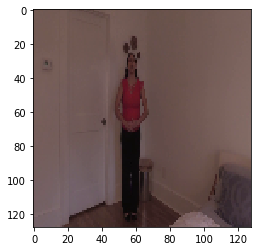

In [60]:
TRAIN_PATH = Path('../input/deepfake-detection-challenge/train_sample_videos/')

frame = read_frame(TEST_PATH/test_videos[142])  # Read first frame
plt.imshow(frame)

In [56]:
%%time 
detections = facedet.predict_on_image(frame)
detections.shape

CPU times: user 25.6 ms, sys: 3.86 ms, total: 29.5 ms
Wall time: 7.56 ms


torch.Size([0, 17])

In [61]:
facedet.input_size

(128, 128)

In [19]:
%%time

frames_per_video=40
test_videos = sorted([x for x in os.listdir(TEST_PATH) if x[-4:] == ".mp4"])

predict_on_videos_original(test_videos[142])

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/luan/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/luan/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/home/luan/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 75, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


--VERDICT  
The problem is probably because it uses 128x128. Either change the resoltuion, looking at the original face extraction or new face detector :D